# 자연어와 단어 분산 표현

## 2.1. 단어의 의미

## 2.2. 시소러스

In [46]:
heavy 

SyntaxError: invalid syntax (<ipython-input-46-4eedbc8f1966>, line 1)

## 통계 기반 기법

In [1]:
import sys
sys.path.append('..')
import os
from common.np import *

## 2.3.1. 파이썬으로 말뭉치 전처리하기


In [1]:
text = 'You say goodbye and I say hello'

In [2]:
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello'

In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello']

단어를 텍스트 그대로 조작하면 여러 면에서 불편하다. 
그래서 단어에 ID를 부여하고, ID의 리스트로 이용할 수 있도록 한 번 더 손질하자. 
이를 위한 사전 준비로, 파이썬의 딕셔너리를 이용하여 단어 ID와 단어를 짝지어주는 대응표를 작성하자

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}

In [6]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5}

In [7]:
id_to_word[1]

'say'

In [8]:
word_to_id['hello']

5

'단어 목록' => '단어 ID 목록'으로 변경. 

파이선의 내포 (comprehension) 표기를 사용하여 단어 목록에서 단어 ID 목록으로 변환, 다시 넘파이 배열로 변환한다

In [9]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5])

말뭉치를 사용하기 위한 사전 준비 완료. 이상의 처리를 한 데 모아 preprocess()라는 함수로 구현하자. (common/util.py)

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

말뭉치 전처리 끝. 

corpus = 단어 ID 목록, 
word_to_id = 단어 ID로의 딕셔너리, 
id_to_word = 단어 ID에서 단어로 딕셔너리

이제 단어의 '의미'를 추출하자  그중 한 방법으로 '통계 기반 기법'을 이번 절에서 살펴보자. 이 기법을 사용해 우리는 단어를 벡터로 표현할 수 있다

## 2.3.2. 단어의 분산 표현

## 2.3.3. 분포 가설

## 2.3.4. 동시발생 행렬

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

In [7]:
!pwd

/Users/yklee/study/deep-learning-from-scratch-2


<img src = ./images_equations/fig2-5.png>

<img src = ./images_equations/fig2-6.png>

<img src = ./images_equations/fig2-7.png>

In [9]:
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [10]:
print(C[0])

[0 1 0 0 0 0 0]


In [11]:
print(C[4])

[0 1 0 1 0 0 0]


In [12]:
print(C[word_to_id['goodbye']])

[0 1 0 1 0 0 0]


In [13]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

## 2.3.5 백터 간 유사도

In [14]:
def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값(1e-8)
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

단어 벡터 간의 유사도를 다음과 같이 구할 수 있다
일례로 you 와 i(=I)의 유사도를 구해보자

In [15]:
# coding: utf-8
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  # "you"의 단어 벡터
c1 = C[word_to_id['i']]    # "i"의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067691154799


'you'와 'i'의 코사인 유사도는 0.70으로 나옴. 코사인 유사도 값 (-1 ~ 1) 치곤 높은 편이다 (유사성이 크다)

## 2.3.6.  유사 단어의 랭킹 표시

most_similar(query, word_to_id, id_to_word, word_matrix, top = 5)

<img src = ./images_equations/table2-1.png>

## most_similar()

1. 검색어의 단어 벡터를 꺼낸다
2. 검색어의 단어 벡터와 다른 모든 단어 벡터와의 코사인 유사도를 각각 구한다.
3. 계산한 코사인 유사도 결과를 기준으로 값이 높은 순서대로 출력한다. 

In [17]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    #1.검색어를 꺼낸다
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    #2. 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    #3. 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

3번에서는 similarity 배열에 담긴 원소의 인덱스를 내림차순으로 정렬한 후, 상위 원소들을 출력함. 
이때 배열 인덱스의 정렬을 바꾸는데 사용한 argsort()메서드는 넘파이 배열의 원소를 오름차순으로 정렬한다 (단, 반환값은 배열의 인덱스다). 
예시: 

In [18]:
 x = np.array([100, -20, 2])
x. argsort()

array([1, 2, 0])

[100,-20,2] <- 인덱스가 1인 원소(-20), 2인 원소(2), 0인 원소(100) 순으로 정렬된 것임

우리가 원하는 건 유사도가 '큰' 순서대로 정렬하는 것이니 각 원소에 마이너스를 곱한후 argsort()메소드를 호출하면 된다. 

In [19]:
(-x).argsort()

array([0, 2, 1])

이를 사용하면 단어의 유사도가 높은 순서로 출력 가능하다. 이상이 most_similar()함수의 구현이다. 이제 이 함수를 사용해보자. You를 검색어로 지정해 유사한 단어들을 출력해보자

In [20]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
c = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top = 5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


이 결과는 검색어 'you'와 유사한 단어 상위 5개만을 출력한 것임. 

코사인 유사도는 해당 단어의 오른쪽에서 볼 수 있다. 

앞의 결과를 보면 you에 가장 가까운 단어는 총 3개인데, 차례로 goodbye, i, hello다. i는 인칭대명사이므로 유사도가 높다는게 납득이 되지만, goodbye가 높다는건 이상함. 말뭉치의 크기가 너무 작다는 것이 원인. 나중에 더 큰 말뭉치를 사용하여 똑같은 실험을 할 것임.



# 2.4. 통계 기반 기법 개선하기

## 2.4.1. 상호정보량

고빈도 단어(많이 출현하는 단어)일수록 쿼리로 들어온 단어와 더 유사하다고 분류될 가능성이 높음.

이 문제를 해결하기 위해 **점별 상호정보량 pointwise mutual information (PMI)**라는 척도를 사용함.



In [21]:
!pwd

/Users/yklee/study/deep-learning-from-scratch-2


#### PMI는 확률 변수 x 와 y에 대해 다음과 같이 정의된다. 


<img src = "./images_equations/e2-2.png">

<img src = "./images_equations/e2-3.png">

<img src = "./images_equations/e2-4.png">

<img src = "./images_equations/e2-5.png">


----

이제 PMI라는 멋진 척도를 얻었지만, 한가지 문제가 있다. 

바로 두 단어의 동시발생 횟수가 0이면 log_20=-infinity가 된다는 점이다. 

이 문제를 피하기 위해 실제로 구현할 때는 양의 상호정보량 (Positive PMI; PPMI)을 사용한다

<img src = "./images_equations/e2-6.png">

이 식에 따라 PMI가 음수일때는 0으로 취급한다. 

이제 단어 사이의 관련성을 0이상의 실수로 나타낼 수 있다. 

그러면 동시발생 행렬을 PPMI행렬로 변환하는 함수를 구현해보자

이 함수의 이름은 ```ppmi(C, verbose = False, eps = 1e-8)```로 짓겠다 (common/util.py)



In [22]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M


여기에서 인수 C는 동시발생 행렬, verbose는 진행상황 출력 여부를 결정하는 플래그다. 

큰 말뭉치를 다룰 때 ```verbose = True ```로 설정하면 중간중간 진행 상황을 알려준다 (이 코드는 동시발생행렬에 대해서만 ppmi행렬을 구할 수 있도록 하고자 단순화해 구현한 것이다. 그리고 np.log2(0)이 음의 무한대(-inf)가 되는 사태를 피하기 위해eps라는 작은 값을 사용함

그럼, 동시발생 행렬을 ppmi행렬로 변환해보자

이는 다음처럼 구현 할 수 있다 

In [24]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


이때 ppmi 행렬의 각 원소는 0 이상의 실수다. 이제 우리는 더 좋은 척도로 이뤄진 행렬 (더 좋은 단어 벡터)을 손에 쥐었다!

그러나 여기에도 큰 문제가 있다: 말뭉치 어휘수 증가와 각 단어의 벡터 차원수가 비례하게 증가한다. 

그리고 대부분의 원소가 0이다 = too sparse!

==> 벡터 차원 감소가 필요

### 2.4.2. 차원 감소

차원 감소(dimensionality reduction)은 문자 그대로 벡터의 차원을 줄이는 방법이다.

단순히 줄이기만 하는게 아니라 '중요한 정보'는 최대한 유지하면서 줄이는게 핵심이다

그림 [2-8] 처럼 데이터의 분포를 고려해 중요한 '축'을 찾는 일을 수행한다

<img src = "./images_equations/fig2-8.png">

### SVD (singular value decomposition) 

차원 축소 방법 중 하나. 

SVD는 임의의 행렬을 세 행렬의 곱으로 분해한다. 

<img src = "./images_equations/e2-7.png">

위 식(2-7)과 같이 SVD는 임의의 행렬 X를 U, S, V라는 세 행렬의 곱으로 분해한다. 여기서 U 와 V는 직교행렬ortogonal matrix이고, 그 열벡터는 서로 직교한다. 또한 S는 대각행렬 diagonal matrix (대각성분 외에는 모두 0인 행렬)입니다. 이 수식을 시각적으로 표현하는 것이 그림2-9이다. 

<img src = "./images_equations/fig2-9.png">

식 2-7에서 U는 직교행렬이다. 그리고 이 직교행렬은 어떠한 공간의 축 (기저)을 형성한다. 

지금 우리의 맥락에서는 이 U행렬을 '단어 공간'으로 취급할 수 있다

또한 S는 대각 행렬로, 그 대각성분에는 '특잇값singular value'이 큰 순서로 나열되어있다. 
특잇값이란, '해당 축'의 중요도라고 간주할 수 있다.

그래서 그림 2-10과 같이 중요도가 낮은 원소 (특잇값이 작은 원소)를 깎아내는 방법을 생각할 수 있다


<img src = "./images_equations/fig2-10.png">

**행렬 S**에서 **특잇값이 작다면 중요도가 낮다**는 뜻이다. => 행렬 U에서 여분의 열벡터를 깍아내어 원래의 행렬을 근사할 수 있다. 


이를 우리 문제로 가져와서 '단어의 ppmi 행렬'에 적용해보자. (행렬 X의 각 행에는 해당 단어 ID의 단어 벡터가 저장되어 있으며, 그 단어 벡터가 행렬 U라는 차원 감소된 벡터로 표현되는 것이다. 

### 2.4.3. SVD에 의한 차원 감소

이제 SVD를 파이썬 코드로 살펴보자

SVD 는 넘파이의 ```linalg```모듈이 제공하는 svd메서드로 실행할 수 있다. 

참고로 ```linalg```는 선형대수(linear algebra)의 약어이다. 그럼, 동시발생 행렬을 만들어 PPMI행렬로 변환한 다음 SVD를 적용해보자 (ch02/count_method_small.py)



[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


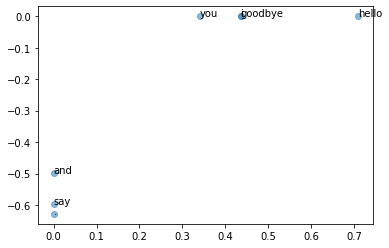

In [25]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print(C[0])
print(W[0])
print(U[0])

# 플롯
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

이제 SVD를 수행할 수 있다. 이 코드에서 SVD에 의해 변환된 밀집 벡터 표현은 변수 U에 저장된다. 

다음으로는 실제 내용을 살펴보자. 단어 ID 가 0인 단어 벡터를 보자. 



In [26]:
print(C[0]) #동시 발생 행렬

[0 1 0 0 0 0 0]


In [27]:
print(W[0])

[0.    1.807 0.    0.    0.    0.    0.   ]


In [28]:
print(U[0])

[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


이 결과에서 보듯 원래는 희소벡터인 W[0]가 SVD에 의해서 밀집벡터 U[0]로 변했다. 

그리고 이 밀집벡터의 차원을 감소시키려면, 예컨데 2차원 벡터로 줄이려면 단순히 처음의 두 원소를 꺼내면 된다. 

In [29]:
print(U[0, :2])

[0.341 0.   ]


이것으로 차원 감소도 다 알아보았다. 그러면 각 단어를 2차원 벡터로 표현한 후 그래프로 그려보자. 다음 코드를 추가하면 된다. 



In [36]:
import matplotlib.pyplot as plt

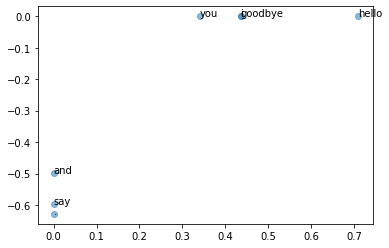

In [42]:
#동시발생 행렬에 SVD를 적용한 후, 각 단어를 2차원 벡터로 변환해 그린 그래프 ('i'와 'goodbye'가 겹쳐있음)

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

그림 2-11을 보면 'goodbye'와 'hello', 'you'와 'i'가 제법 가까이 있음을 알 수 있다. 

우리의 직관과 비교적 비슷하다. 하지만 지금 사용한 말뭉치가 아주 작아서 이 결과를 그대로 받아들이기에는 솔직히 석연치 않다. 

그러면 계속해서 PTB 데이터셋이라는 더 큰 말뭉치를 사용하여 똑같은 실험을 수행해보자. 

우선은 PTB데이터셋이 무엇인지부터 간단히 설명하겠다. 


### 2.4.4. PTB 데이터셋

본격적으로 사이즈가 있는 말뭉치를 (그렇다고 너무 헤비하지 않은) 말뭉치를 이용해보겠다. 

PTB  = Penn TreeBank
주어진 기법의 품질을 측정하는 벤치마크로 자주 이용된다.
이는 미콜로프(Mikolov)의 웹페이지에서 받을 수 있다. 
이 PTB 말뭉치는 텍스트 파일로 제공되며, 원래의 PTB 문장에 몇가지 전처리를 해두었다.

예시
<img src = "./images_equations/fig2-12.png">

한 문장 = 하나의 줄로 저장되어 있음. 이 책에서는 각 문장을 연결한 '하나의 큰 시계열 데이터'로 취급하겠다. 이때 각 문장 끝에 <eos>라는 특수 문자를 삽입한다 (end of sentence의 약어)
    
이 책에서는 PTB데이터셋을 쉽게 이용할 수 있도록 전용 파이썬 코드를 준비했다. 이 코드는 dataset/ptb.py 파일에 담겨있으며 작업 디렉터리가 '각 장의 디렉터리(ch01, ch02, .. )라고 가정하고 동작한다. 
    
예를 들어 터미널에서 ch02 디렉터리로 이동한 다음  python_show_ptb.py 명령을 실행하면 된다. 다음은 ptb.py를 사용하는 예이다. 
    
    

In [43]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])


Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


데이터설명:


- corpus 에는 단어 ID 목록이 저장된다. 
- id_to_word 는 단어ID에서 단어로 변환하는 딕셔너리이다
- word_to_id는 단어에서 단어ID로 변환하는 딕셔너리이다

앞의 코드에서 ptb.load_data()는 데이터를 읽어들인다. 

이때 인수로는 'train', 'test', 'valid' 중 하나를 지정할 수 있는데, 차례대로 '훈련용', '테스트용', '검증용' 데이터를 가리킨다. 

### 2.4.5. PTB 데이터셋 평가

PTB 데이터셋에 통계 기반 기법을 적용해보자. 

이번에는 큰 행렬에 SVD를 적용해야 하므로 고속 SVD를 이용하는 것을 추천한다

고속 SVD를 이용하려면 sklearn 모듈을 설치해야한다 

물론 간단한 SVD(np.linalg.svd())도 사용할 수 있다만, 시간이 오래 걸리며 메모리도 훨씬 많이 사용한다

자, 그럼 소스 코드를 보자 (ch02/count_method_big.py)



이 코드는 SVD를 수행하는데 sklearn의 randomized_svd() 메서드를 이용했다. 이 메서드는 무작위 수를 사용한 Truncated SVD로, 특잇값이 큰 것들만 계산하여 기본적인 SVD보다 훨씬 빠르다. 나머지 부분은 앞서 작은 말뭉치를 사용한 코드와 거의 같다. 


이제 이 코드를 실행해보자. 실행 결과는 다음과 같다. 참고로 Truncated SVD는 무작위수를 사용하므로 결과가 매번 다르다

In [44]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
calculating SVD ...

[query] you
 i: 0.6792336702346802
 we: 0.6460341811180115
 d

In [45]:
결과를 보면, 우선 you라는 검색어에서는 i와 we가 상위를 차지했음을 알 수 있다 (영어 문장에서 관용적으로 사용 빈도가 높기 때문)
year - month- quarter

car- auto- vehicle

toyota-nissan-honda-lexus

이처럼 단어의 의미 혹은 문법적인 관점에서 비슷한 단어들이 가까운 벡터로 나타난다. 우리의 직관과 비슷한 결과라고 할 수 있다. 

SyntaxError: invalid syntax (<ipython-input-45-d419676ba8a4>, line 1)

Congrats! 마침내 '단어의 의미'를 벡터로 잘 인코딩하는데 성공했다! 
말뭉치를 사용해 맥락에 속한 단어의 등장 횟수를 센 후 ppmi행렬로 변환하고 => 다시 SVD를 이용해 차원을 감소 (better word vectors!) . 이것이 단어의 분산 표현이고, 각 단어는 고정 길이의 밀집 벡터로 표현된다. 

----


이번 장에서는 단어 몇개만 선택한 후 유사 단어를 살펴보았다

하지만 다른 수많은 단어에서도 같은 성질을 확인할 수 있다

또한 대규모 말뭉치를 사용하면 단어의 분산 표현의 품질도 더 좋아질 것이다

----


### 2.5. 정리

이번 장에서는 자연어를 대상으로, 특히 컴퓨터에게 '단어의 의미' 이해시키기를 주제로 이야기를 진행함

이 목적을 달성하기 위한 여정으로, 먼저 시소러스를 이용한 기법을 설명한 후, 이어서 통계 기반 기법을 살펴봄

- 시소러스 기반 기법은 단어들의 관련성을 사람이 수작업으로 하나씩 정의함. 매우 힘들고 표현력에도 한계가 있음
- 통계 기반 기법은 말뭉치로부터 단어 의미를 자동 추출, 그 의미를 벡터로 표현함. 단어의 동시발생행렬을 만들고 ppmi행렬로 변환한 다음, 안정성을 높이기 위해 svd를 이용해 차원을 감소시켜 각 단어의 분산 표현을 만듦. 그리고 그 분산 표현에 따르면 의미가 (그리고 문법적인 용법면에서) 비슷한 단어들이 벡터 공간에서도 서로 가까이 모여 있음을 확인함

여기서 다룬 cos_similarity()함수와 most_similar()함수는 다음장 이후에도 사용할 것임